In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

### Helpers for using DBSCAN to create clusters and viewing them

In [165]:
# Uses DBSCAN to assign labels of a particular type and property to clusters
def DBSCAN_label_subset(filename, eps, min_samples, l_type, l_prop):
    df = pd.read_csv(filename, delimiter='\t')
    
    # dbscan expects multiple dimensions
    df["zeros"]=0
    
    # filter by type and property if given
    if l_type is not None:
        df = df.loc[df["node1"] == l_type]
    if l_prop is not None:
        df = df.loc[df["label"] == l_prop]
        
    values_w_0s = df.loc[:, ["node2", "zeros"]]
    values = values_w_0s.loc[:,"node2"]
    
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(values_w_0s)

    return (db, values)


# Chooses values for the epsilon and min_samples parameters of DBSCAN to be used for
# clustering labels of a given type and property.
def choose_DBSCAN_params(filename, l_type, l_prop):
    df = pd.read_csv(filename, delimiter='\t')
    
    # filter by type and property if given
    if l_type is not None:
        df = df.loc[df["node1"] == l_type]
    if l_prop is not None:
        df = df.loc[df["label"] == l_prop]
        
    values = np.array(df.loc[:,"node2"]).reshape(-1, 1)
    
    # min_samples would ideally be set with some domain-insight.
    # To make this automated, we'll use a heuristic - ln(number of data points)
    min_samples = int(np.floor(np.log(len(values))))
    min_samples = max(min_samples, 1) # don't choose a number less than 1
    print("Choosing min_samples = floor(ln(# data points)) = {}".format(min_samples))
    
    # epsilon can be chosen by plotting the distances of the k'th nearest neighbor from each point
    # where k is min_samples. Points that belong to clusters should have smaller distances, whereas
    # noise points can have distances that are much farther. We'll look for a knee in this graph to set epsilon.
    print("Computing distances to k'th nearest neighbor for each point where k = min_samples...")
    
    neigh = NearestNeighbors(n_neighbors = min_samples + 1) # +1 so we find k'th nearest neighbor not including the point iteslf.
    values_neigh = neigh.fit(values)
    distances, indices = values_neigh.kneighbors(values)
    distances = np.sort(distances[:,min_samples], axis = 0)
    
#     plt.plot(distances)
#     plt.xlabel("points in increasing order of distance to k'th nearest neighbor")
#     plt.ylabel("distance to k'th nearest neighbor")
    
    kneedle = KneeLocator(range(len(distances)), distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
    kneedle.plot_knee()
    plt.xlabel("Points")
    plt.ylabel("Distance")

    print("knee found at distance {}".format(kneedle.knee_y))
    epsilon = kneedle.knee_y
    
    return (min_samples, epsilon)


# Given values that have been assigned to clusters,
# return a list of intervals that are consistent with these clusters
def infer_intervals_from_clusters(values, labels):
    
    values = np.array(values)
    labels = np.array(labels)
    
    # sort values and corresponding labels in ascending order
    labels = np.array([l for l, v in sorted(zip(labels, values), key=lambda pair: pair[1])])
    values.sort()
    
    intervals = [(None, None)] # initially a single interval with no lower or upper bound
    
    cur_label = labels[0]
    for i in range(len(labels)):
        # if new label, set upper bound of previous interval,
        # and start lower bound of a new interval.
        if labels[i] != cur_label:
            prev_interval_lb = (intervals[-1])[0]
            new_interval_edge = values[i-1] + ((values[i] - values[i-1]) / 2)
            intervals[-1] = (prev_interval_lb, new_interval_edge)
            intervals.append((new_interval_edge, None))
            cur_label = labels[i]
    
    return intervals
    

def fixed_width_partition(filename, width, l_type, l_prop):
    df = pd.read_csv(filename, delimiter='\t')
    
   # filter by type and property if given
    if l_type is not None:
        df = df.loc[df["node1"] == l_type]
    if l_prop is not None:
        df = df.loc[df["label"] == l_prop]
        
    values = df.loc[:,"node2"]
    labels = values - (values % width)
    
    return (labels, values)
    

def view_clustering(labels, values, min_hist_bin = None, max_hist_bin = None):
    if min_hist_bin is None:
        min_hist_bin = values.min() - 1
    if max_hist_bin is None:
        max_hist_bin = values.max() + 1
    
#     labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)


    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    
    ax = plt.gca()
    ax.set_facecolor("xkcd:silver")

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = values.loc[class_member_mask]
        plt.hist(xy, color=tuple(col), bins = range(min_hist_bin, max_hist_bin, 1))

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()

File paths for passing in python

In [20]:
path = "/Users/nicklein/Documents/grad_school/Research/data/Q44_profiler_output/"
year_file = "{}Q44.entity_attribute_labels_time.year.tsv".format(path)


File paths for using in kgtk commands

In [21]:
work_dir = "/Users/nicklein/Documents/grad_school/Research/data"

In [26]:
os.environ['STORE'] = "{}/wikidata.sqlite3.db".format(work_dir)
os.environ['DATA'] = "{}/Q44".format(work_dir)
os.environ['NAME'] = "Q44"
os.environ["OUT"] = "{}/Q44_profiler_output".format(work_dir)

## year values

Taking a look at most prevalent type, property pairs

In [102]:
!head -5 $OUT/$NAME.entity_attribute_labels_time.year.tsv | column -t -s $'\t'

entity  node1     label  node2  type_label            property_label  id
Q1011   Q112099   P571   1975   'island nation'@en    'inception'@en  E1
Q1011   Q3624078  P571   1975   'sovereign state'@en  'inception'@en  E2
Q1019   Q112099   P571   1960   'island nation'@en    'inception'@en  E3
Q1019   Q3624078  P571   1960   'sovereign state'@en  'inception'@en  E4


In [103]:
!kgtk query -i $OUT/$NAME.entity_attribute_labels_time.year.tsv \
--graph-cache $STORE \
--match 'year: (type)-[l {label:p, entity:e, type_label:t_lab, property_label:p_lab}]->(val)' \
--return 'type as type, p as prop, count(e) as count, t_lab as type_label, p_lab as property_label' \
--order-by 'count(e) desc' \
--limit 5 \
| column -t -s $'\t'

type      prop  count  type_label            property_label
Q3624078  P571  88     'sovereign state'@en  'inception'@en
Q4830453  P571  50     'business'@en         'inception'@en
Q131734   P571  45     'brewery'@en          'inception'@en
Q6256     P571  31     'country'@en          'inception'@en
Q6881511  P571  24     'enterprise'@en       'inception'@en


Let's start by looking at year values for type = **business** prop = **inception**

First let's take a look at what triples match these labels...

In [104]:
!kgtk query -i $OUT/$NAME.entity_attribute_labels_time.year.tsv -i $DATA/$NAME.label.en.tsv \
--graph-cache $STORE \
--match 'year: (type)-[l {label:p, entity:e, type_label:t_lab, property_label:p_lab}]->(val), label: (e)-[:label]->(e_lab)' \
--return 'distinct e as entity, type as type, p as prop, val as year, e_lab as entity_label, t_lab as type_label, p_lab as property_label' \
--where 'type = "Q4830453" AND p = "P571" AND e_lab.kgtk_lqstring_lang_suffix = "en"' \
--order-by 'kgtk_quantity_number_int(val)' \
--limit 10 \
| column -t -s $'\t'

entity     type      prop  year  entity_label                    type_label     property_label
Q562552    Q4830453  P571  1333  'Oettinger Brewery'@en          'business'@en  'inception'@en
Q153075    Q4830453  P571  1615  'Grolsch Brewery'@en            'business'@en  'inception'@en
Q1397604   Q4830453  P571  1664  'Kronenbourg Brewery'@en        'business'@en  'inception'@en
Q12002324  Q4830453  P571  1698  'Shepherd Neame Brewery'@en     'business'@en  'inception'@en
Q1164954   Q4830453  P571  1769  'Dubuisson Brewery'@en          'business'@en  'inception'@en
Q609966    Q4830453  P571  1795  'Budweiser Bier Bürgerbräu'@en  'business'@en  'inception'@en
Q2601227   Q4830453  P571  1819  'Sinebrychoff'@en               'business'@en  'inception'@en
Q3640368   Q4830453  P571  1846  'Peroni'@en                     'business'@en  'inception'@en
Q865859    Q4830453  P571  1846  'Peroni Brewery'@en             'business'@en  'inception'@en
Q113215    Q4830453  P571  1847  'Carlsberg Group'

eps = 5, minpts = 1

Estimated number of clusters: 20
Estimated number of noise points: 0


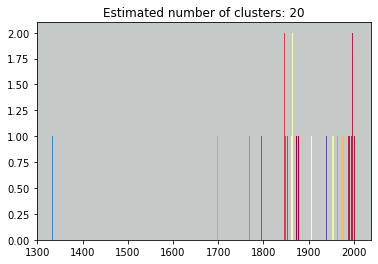

In [118]:
db_bus_incep, values_bus_incep = DBSCAN_label_subset(year_file, l_type = "Q4830453", l_prop = "P571", eps = 5, min_samples = 1)
view_clustering(db_bus_incep.labels_, values_bus_incep)

zooming in...

Estimated number of clusters: 20
Estimated number of noise points: 0


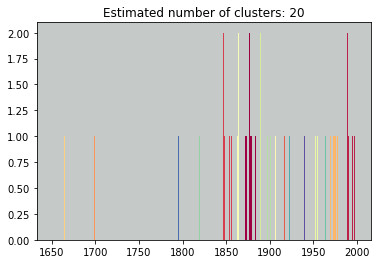

In [106]:
view_clustering(db_bus_incep.labels_, values_bus_incep, 1650, 2000)

eps = 10, minpts = 1

Estimated number of clusters: 11
Estimated number of noise points: 0


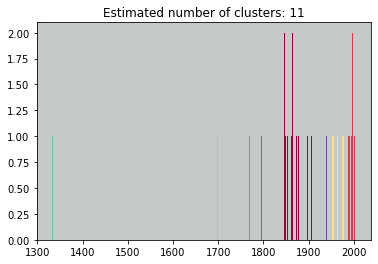

In [107]:
db_bus_incep, values_bus_incep = DBSCAN_label_subset(year_file, l_type = "Q4830453", l_prop = "P571", eps = 10, min_samples = 1)
view_clustering(db_bus_incep.labels_, values_bus_incep)

zooming in...

Estimated number of clusters: 11
Estimated number of noise points: 0


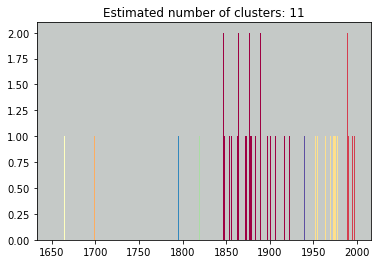

In [108]:
view_clustering(db_bus_incep.labels, values_bus_incep, 1650, 2000)

eps = 5, minpts = 10

Estimated number of clusters: 8
Estimated number of noise points: 12


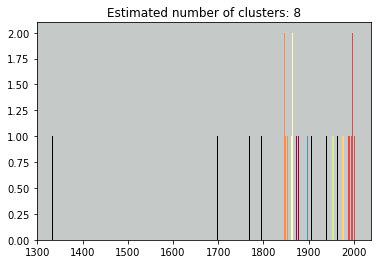

In [109]:
db_bus_incep, values_bus_incep = DBSCAN_label_subset(year_file, l_type = "Q4830453", l_prop = "P571", eps = 5, min_samples = 2)
view_clustering(db_bus_incep.labels_, values_bus_incep)

zooming in...

Estimated number of clusters: 8
Estimated number of noise points: 12


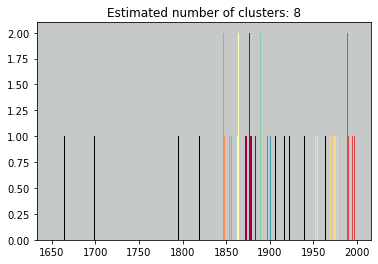

In [110]:
view_clustering(db_bus_incep.labels, values_bus_incep, 1650, 2000)

If instead we just use a fixed width of 5 years...

In [130]:
labels_bus_incep, values_bus_incep = fixed_width_partition(year_file, width = 5, l_type = "Q4830453", l_prop = "P571")

Estimated number of clusters: 31
Estimated number of noise points: 0


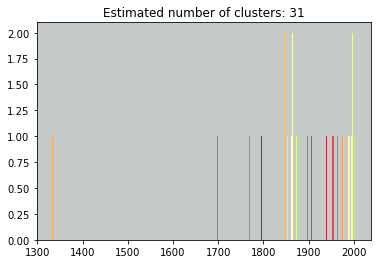

In [131]:
view_clustering(labels_bus_incep, values_bus_incep)

zooming in...

Estimated number of clusters: 31
Estimated number of noise points: 0


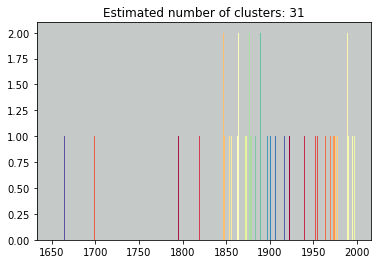

In [133]:
view_clustering(labels_bus_incep, values_bus_incep, 1650, 2000)

Now using an automated approach to set parameters

Choosing min_samples = floor(ln(# data points)) = 3
Computing distances to k'th nearest neighbor for each point where k = min_samples...
knee found at distance 27.0


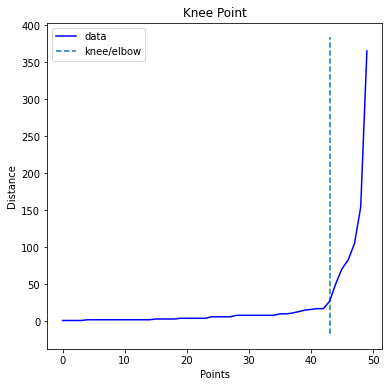

In [166]:
min_samples, epsilon = choose_DBSCAN_params(year_file, l_type = "Q4830453", l_prop = "P571")

Estimated number of clusters: 1
Estimated number of noise points: 4


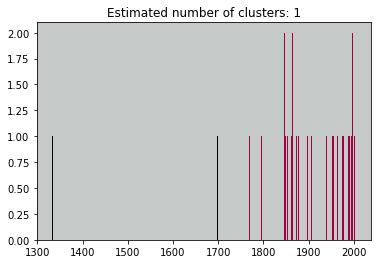

In [155]:
db_bus_incep, values_bus_incep = DBSCAN_label_subset(year_file, l_type = "Q4830453", l_prop = "P571", eps = epsilon, min_samples = min_samples)
view_clustering(db_bus_incep.labels_, values_bus_incep)

Now we'll find intervals that are compatible with the clustering we have

In [164]:
intervals = infer_intervals_from_clusters(values_bus_incep, db_bus_incep.labels_)
print(intervals)

[(None, 1733.5), (1733.5, None)]


Let's also look at year values for type = **brewery** prop = **inception**

triples that match this type and property:

In [111]:
!kgtk query -i $OUT/$NAME.entity_attribute_labels_time.year.tsv -i $DATA/$NAME.label.en.tsv \
--graph-cache $STORE \
--match 'year: (type)-[l {label:p, entity:e, type_label:t_lab, property_label:p_lab}]->(val), label: (e)-[:label]->(e_lab)' \
--return 'distinct e as entity, type as type, p as prop, val as year, e_lab as entity_label, t_lab as type_label, p_lab as property_label' \
--where 'type = "Q131734" AND p = "P571" AND e_lab.kgtk_lqstring_lang_suffix = "en"' \
--order-by 'kgtk_quantity_number_int(val)' \
--limit 10 \
| column -t -s $'\t'

entity     type     prop  year  entity_label                 type_label    property_label
Q153546    Q131734  P571  1328  'Augustiner Bräu'@en         'brewery'@en  'inception'@en
Q562552    Q131734  P571  1333  'Oettinger Brewery'@en       'brewery'@en  'inception'@en
Q566990    Q131734  P571  1405  'Schlenkerla'@en             'brewery'@en  'inception'@en
Q3508302   Q131734  P571  1564  'Svijany Brewery'@en         'brewery'@en  'inception'@en
Q153075    Q131734  P571  1615  'Grolsch Brewery'@en         'brewery'@en  'inception'@en
Q1397604   Q131734  P571  1664  'Kronenbourg Brewery'@en     'brewery'@en  'inception'@en
Q12002324  Q131734  P571  1698  'Shepherd Neame Brewery'@en  'brewery'@en  'inception'@en
Q2319266   Q131734  P571  1759  'Guinness Brewery'@en        'brewery'@en  'inception'@en
Q1164954   Q131734  P571  1769  'Dubuisson Brewery'@en       'brewery'@en  'inception'@en
Q2754546   Q131734  P571  1825  'Gulpener Brewery'@en        'brewery'@en  'inception'@en


In [112]:
db_brew_incep, values_brew_incep = DBSCAN_label_subset(year_file, l_type = "Q131734", l_prop = "P571", eps = 8, min_samples = 1)

Estimated number of clusters: 15
Estimated number of noise points: 0


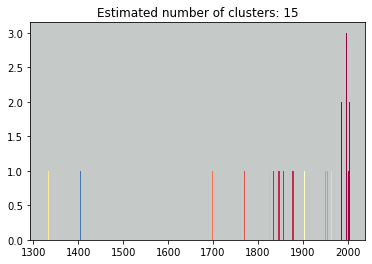

In [113]:
view_clustering(db_brew_incep.labels, values_brew_incep)

Estimated number of clusters: 15
Estimated number of noise points: 0


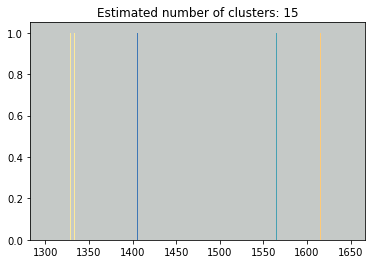

In [114]:
view_clustering(db_brew_incep.labels, values_brew_incep, 1300, 1650)

Estimated number of clusters: 15
Estimated number of noise points: 0


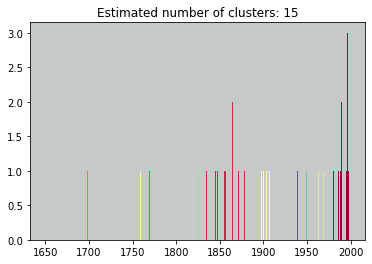

In [115]:
view_clustering(db_brew_incep.labels, values_brew_incep, 1650, 2000)